In [2]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
#%cd "D:\Interfacial Waves resonance videos 0430"
framerate = 29.18


In [3]:
frozen1 = np.loadtxt('data0509/0419_frozenFreqs.dat')
frozen2 = np.loadtxt('data0509/0509_frozenFreqs.dat')

In [4]:
def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev


from scipy.ndimage.filters import uniform_filter

def window_stdev(arr, radius):
    padded = np.zeros(len(arr)+2*radius)
    padded[radius:-radius]= arr
    c1 = uniform_filter(padded, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(padded*padded, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1]
def slidingStd(x, w):
    result = np.zeros_like(x)
    for index in range(len(x)):
#        print(index)
#        print(w)
#        print(min(w, index))
        windowlength = min(w, index)
        if(index>0):
            view = x[index-windowlength:index]
        else:
            view = x[0]
        result[index] = view.std()
    return result


def lin(x, a,b):
    return x*a+b


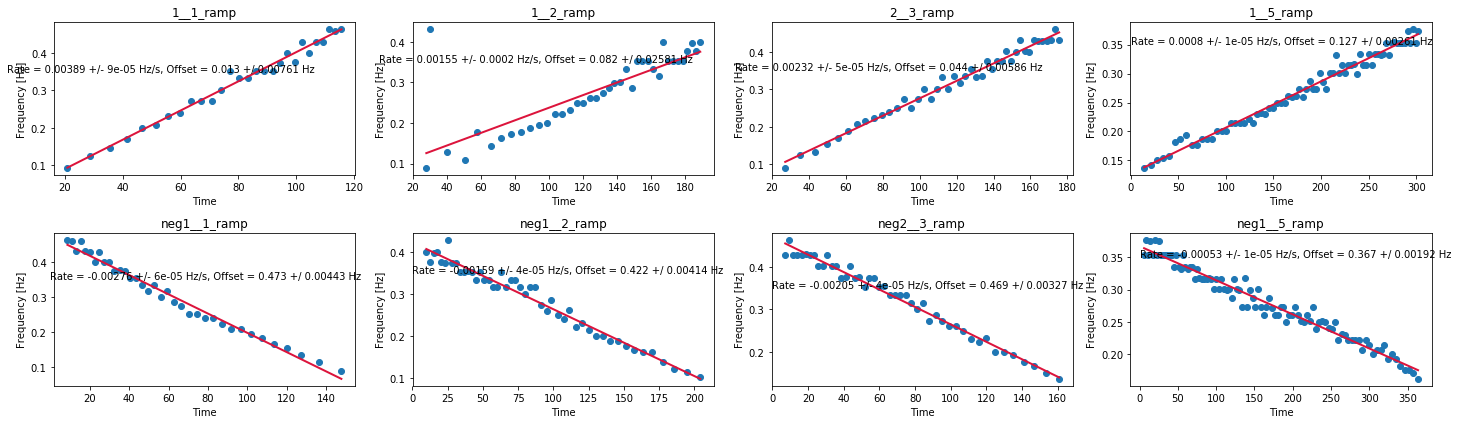

In [17]:
ramps = ['1__1_ramp', '1__2_ramp', '2__3_ramp', '1__5_ramp', 'neg1__1_ramp','neg1__2_ramp', 'neg2__3_ramp', 'neg1__5_ramp']
rampsData = {}
## diagnostics:
fig, axes = plt.subplots(2, 4, figsize=(20,6))
axeslist = axes.flatten()

for i,e in enumerate(ramps):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/driving/%s' %e, skiprows=2)
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal
    N = int(20*fr)
    ax = axeslist[i]
    fr = 1/(driving[1,0]) ##framerate
    
    peaks, _ = find_peaks(driving[:,1]-np.average(driving[:,1]), height=40)
    t = driving[:,0][peaks][1:]

    #f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=N,noverlap=N-1, detrend='constant')
    #dictionary['f'] = f
    #dictionary['t'] = t
    #dictionary['Zxx'] = Zxx
    #dictionary['time'] = driving[:,0]
    #dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    #popt, pcov = curve_fit(lin, t, dictionary['frequencies'])
    #error = np.sqrt(np.diag(pcov))
    filt =  (1./np.diff(driving[:,0][peaks])) < 0.5
    dictionary['frequencies'] =  (1./np.diff(driving[:,0][peaks]))[filt]

    popt, pcov = curve_fit(lin, t[filt], dictionary['frequencies'])
    error = np.sqrt(np.diag(pcov))

    ax.plot(t[filt],  dictionary['frequencies'], 'o')
    ax.plot(t[filt], lin(t[filt], *popt), '-', c='Crimson', linewidth=2.)

    #ax.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    #ax.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.set_title(e)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')
    dictionary['coeffs'] = popt
    dictionary['errors'] = error
    rampsData[e] = {}
    rampsData[e]['driving'] = dictionary
    rampsData[e]['surface'] = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/surface/%s' %e, skiprows=2)
    
fig.tight_layout()

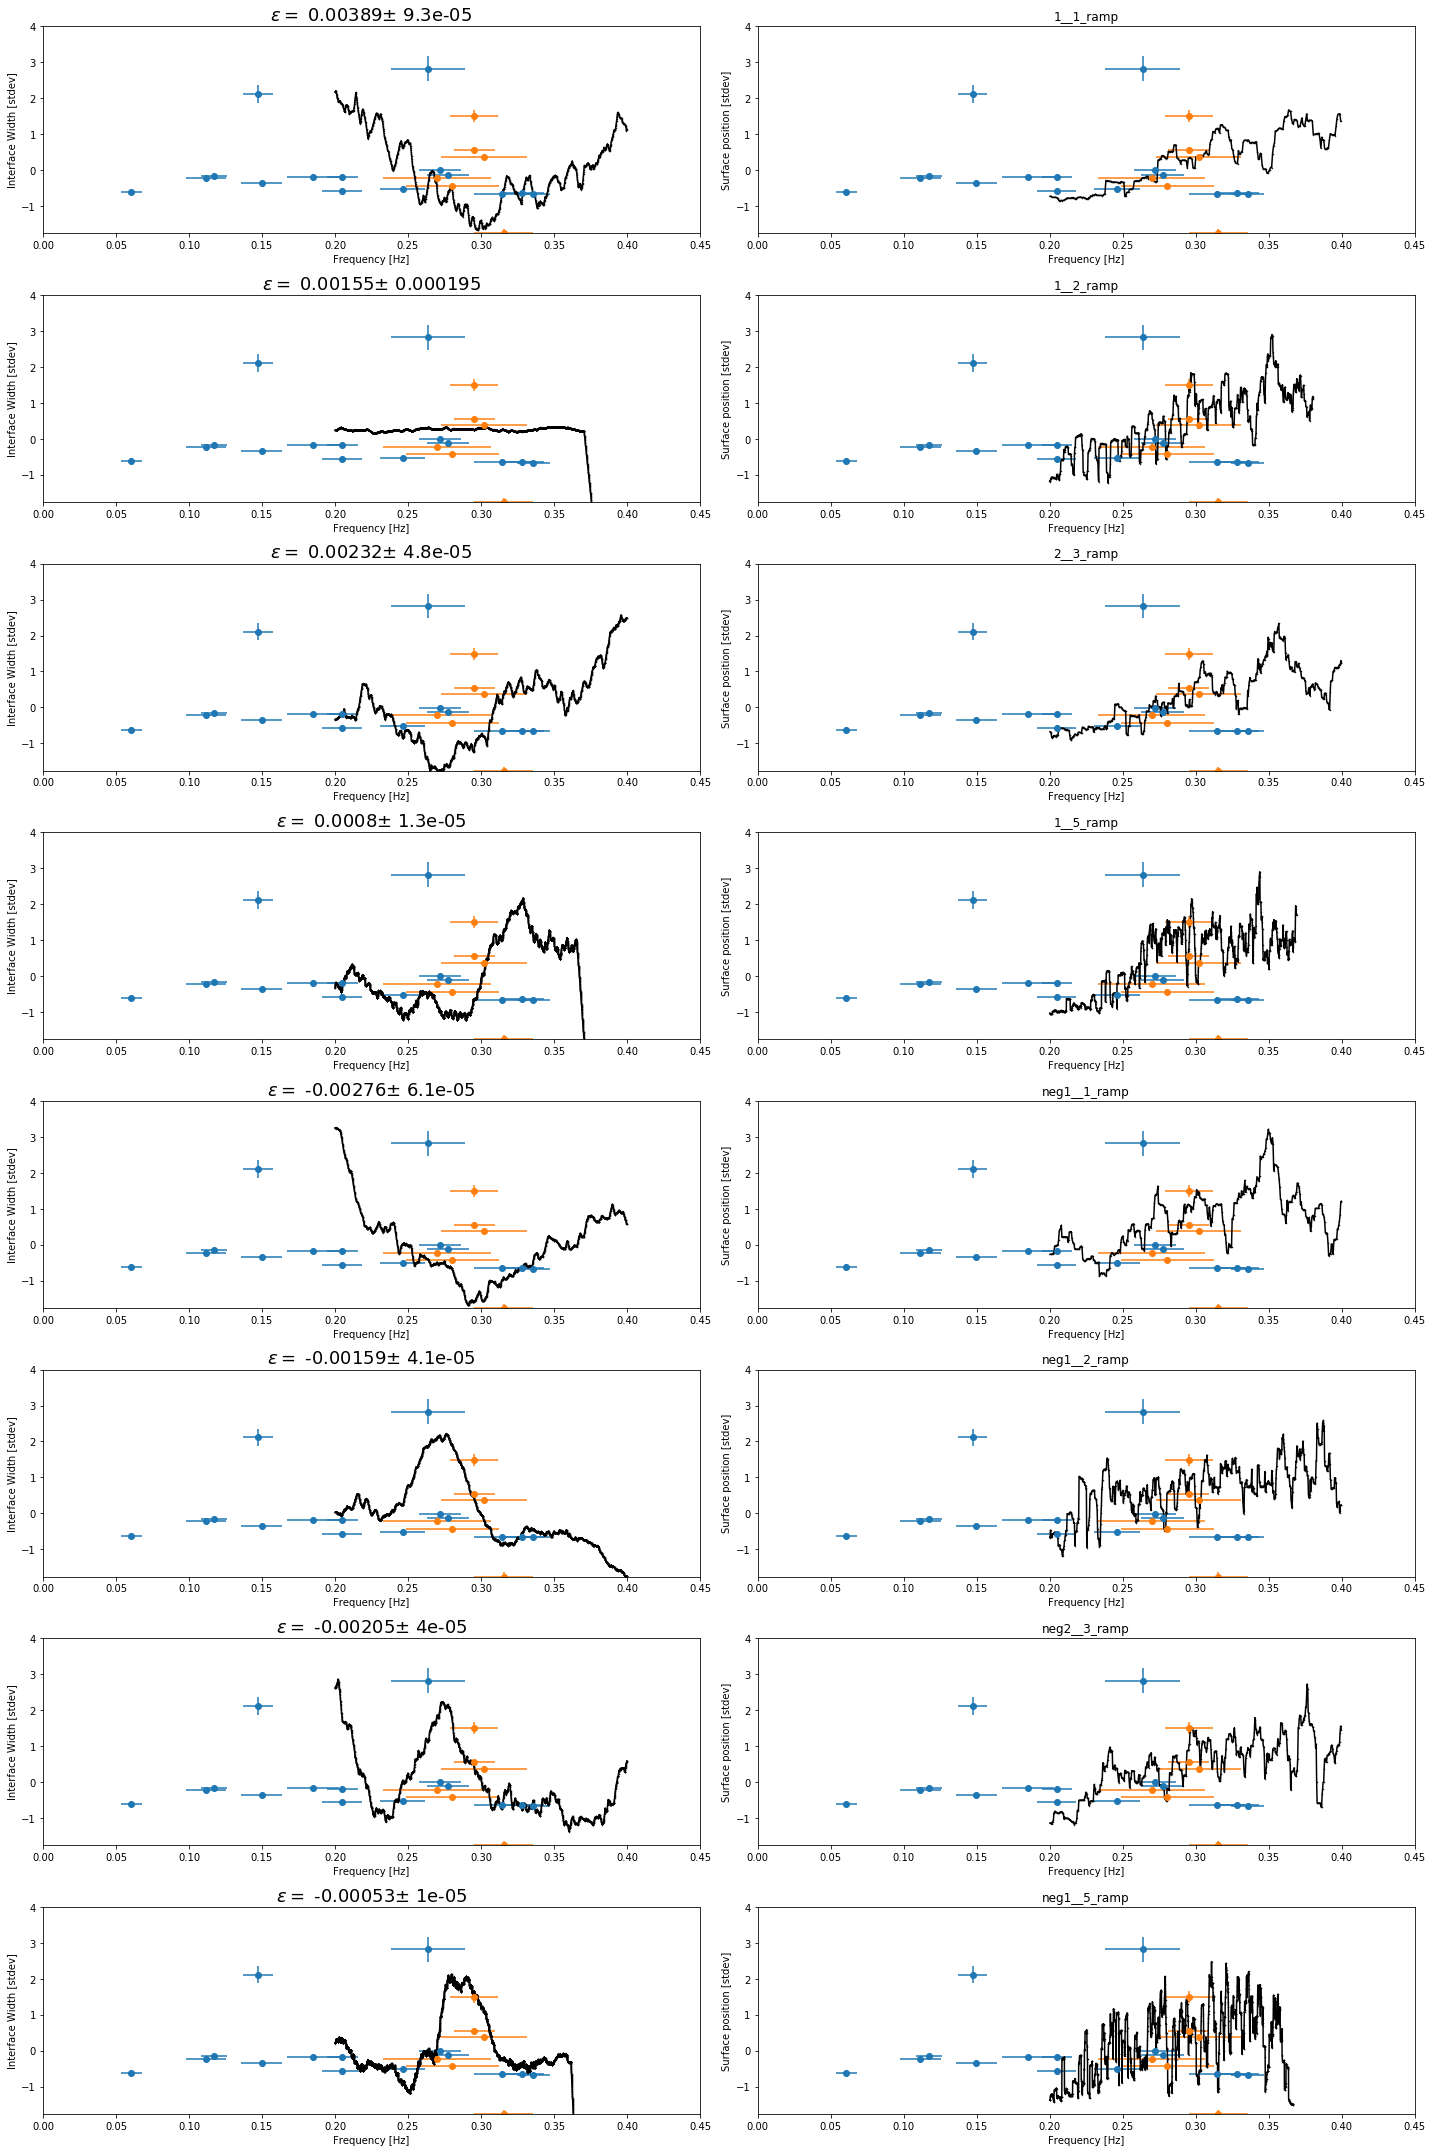

In [19]:
fig, axes = plt.subplots(8,2, figsize=(20,30))
axeslist = axes.flatten()
ramps = ['1__1_ramp', '1__2_ramp', '2__3_ramp', '1__5_ramp', 'neg1__1_ramp','neg1__2_ramp', 'neg2__3_ramp', 'neg1__5_ramp']

for i,e in enumerate(rampsData.values()):
    N = int(20*framerate)
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data/%s.dat' %ramps[i])
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    dictionary['movingAvgw'] = normalize(movingAvgw)
    n = int(20)
    movingStdevSF = slidingStd(e['surface'][:,1], n)
    cont_frequencies = lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs'])
    filt = np.logical_and(cont_frequencies < 0.4, cont_frequencies > 0.2) ## cutting spectrum
    dictionary['surfacePos'] = normalize(movingStdevSF)
    dictionary['time'] = np.arange(0., data.shape[0], 1)/framerate
    ax = axes[:,0][i]
    ax2 = axes[:,1][i]
    ax.plot(cont_frequencies[filt], normalize(movingAvgw[filt]), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.set_title("$\epsilon = $ %s$\pm$ %s" %(round(e['driving']['coeffs'][0], 5), round(e['driving']['errors'][0], 6)) , fontsize=18)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Interface Width [stdev]')
    contFrequenciesSparse = lin(e['surface'][:,0], *e['driving']['coeffs']) ## with different sampling freq.
    filt2 = np.logical_and(contFrequenciesSparse < 0.4, contFrequenciesSparse > 0.2) ## cutting spectrum
    ax2.plot(contFrequenciesSparse[filt2], normalize(movingStdevSF)[filt2], '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax2.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax2.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax2.set_ylim(np.min(frozen2[:,1]), 4.)
    ax2.set_xlim(0., 0.45)
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Surface position [stdev]')
    e['interface'] = dictionary
    ax2.set_title(ramps[i])
    #allData[e] = dictionary
fig.tight_layout()

### Selected Ramps to include

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


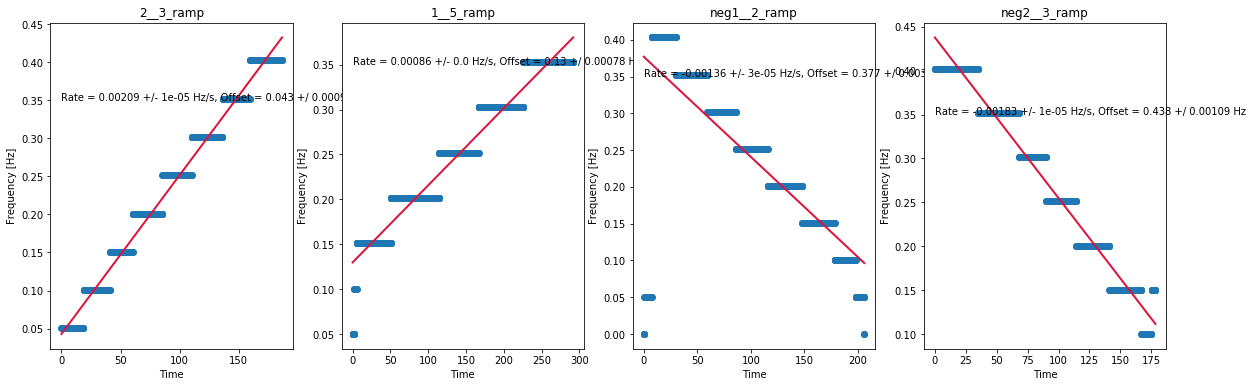

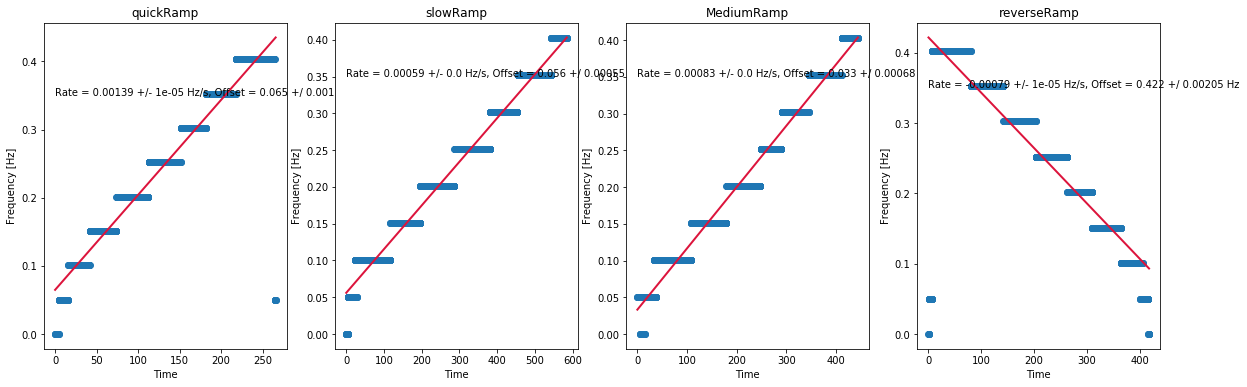

In [200]:
ramps1 = ['2__3_ramp', '1__5_ramp', 'neg1__2_ramp', 'neg2__3_ramp']
ramps2 = ['quickRamp', 'slowRamp', 'MediumRamp', 'reverseRamp']
rampsData = {}
## diagnostics:
fig, axes = plt.subplots(1, 4, figsize=(20,6))
axeslist = axes.flatten()

for i,e in enumerate(ramps1):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/driving/%s' %e, skiprows=2)
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal
    N = int(20*fr)
    ax = axeslist[i]
    fr = 1/(driving[1,0]) ##framerate

    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=N,noverlap=N-1, detrend='constant')
    dictionary['name'] = e
    dictionary['f'] = f
    dictionary['t'] = t
    dictionary['Zxx'] = Zxx
    dictionary['time'] = driving[:,0]
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t, dictionary['frequencies'])
    error = np.sqrt(np.diag(pcov))

    ax.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    ax.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.set_title(e)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')
    dictionary['coeffs'] = popt
    dictionary['errors'] = error
    rampsData[e] = {}
    rampsData[e]['driving'] = dictionary
    rampsData[e]['surface'] = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/surface/%s' %e, skiprows=2)
plt.show()
fig, axes = plt.subplots(1, 4, figsize=(20,6))
axeslist = axes.flatten()

for i,e in enumerate(ramps2):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/driving/%s' %e, skiprows=2)
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal
    N = int(20*fr)
    ax = axeslist[i]
    fr = 1/(driving[1,0]) ##framerate
    dictionary['name'] = e

    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=N,noverlap=N-1, detrend='constant')
    dictionary['f'] = f
    dictionary['t'] = t
    dictionary['Zxx'] = Zxx
    dictionary['time'] = driving[:,0]
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t, dictionary['frequencies'])
    error = np.sqrt(np.diag(pcov))

    ax.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    ax.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.set_title(e)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')
    dictionary['coeffs'] = popt
    dictionary['errors'] = error
    rampsData[e] = {}
    rampsData[e]['driving'] = dictionary
    rampsData[e]['surface'] = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/surfaceResponse/%s' %e, skiprows=2)
    


C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


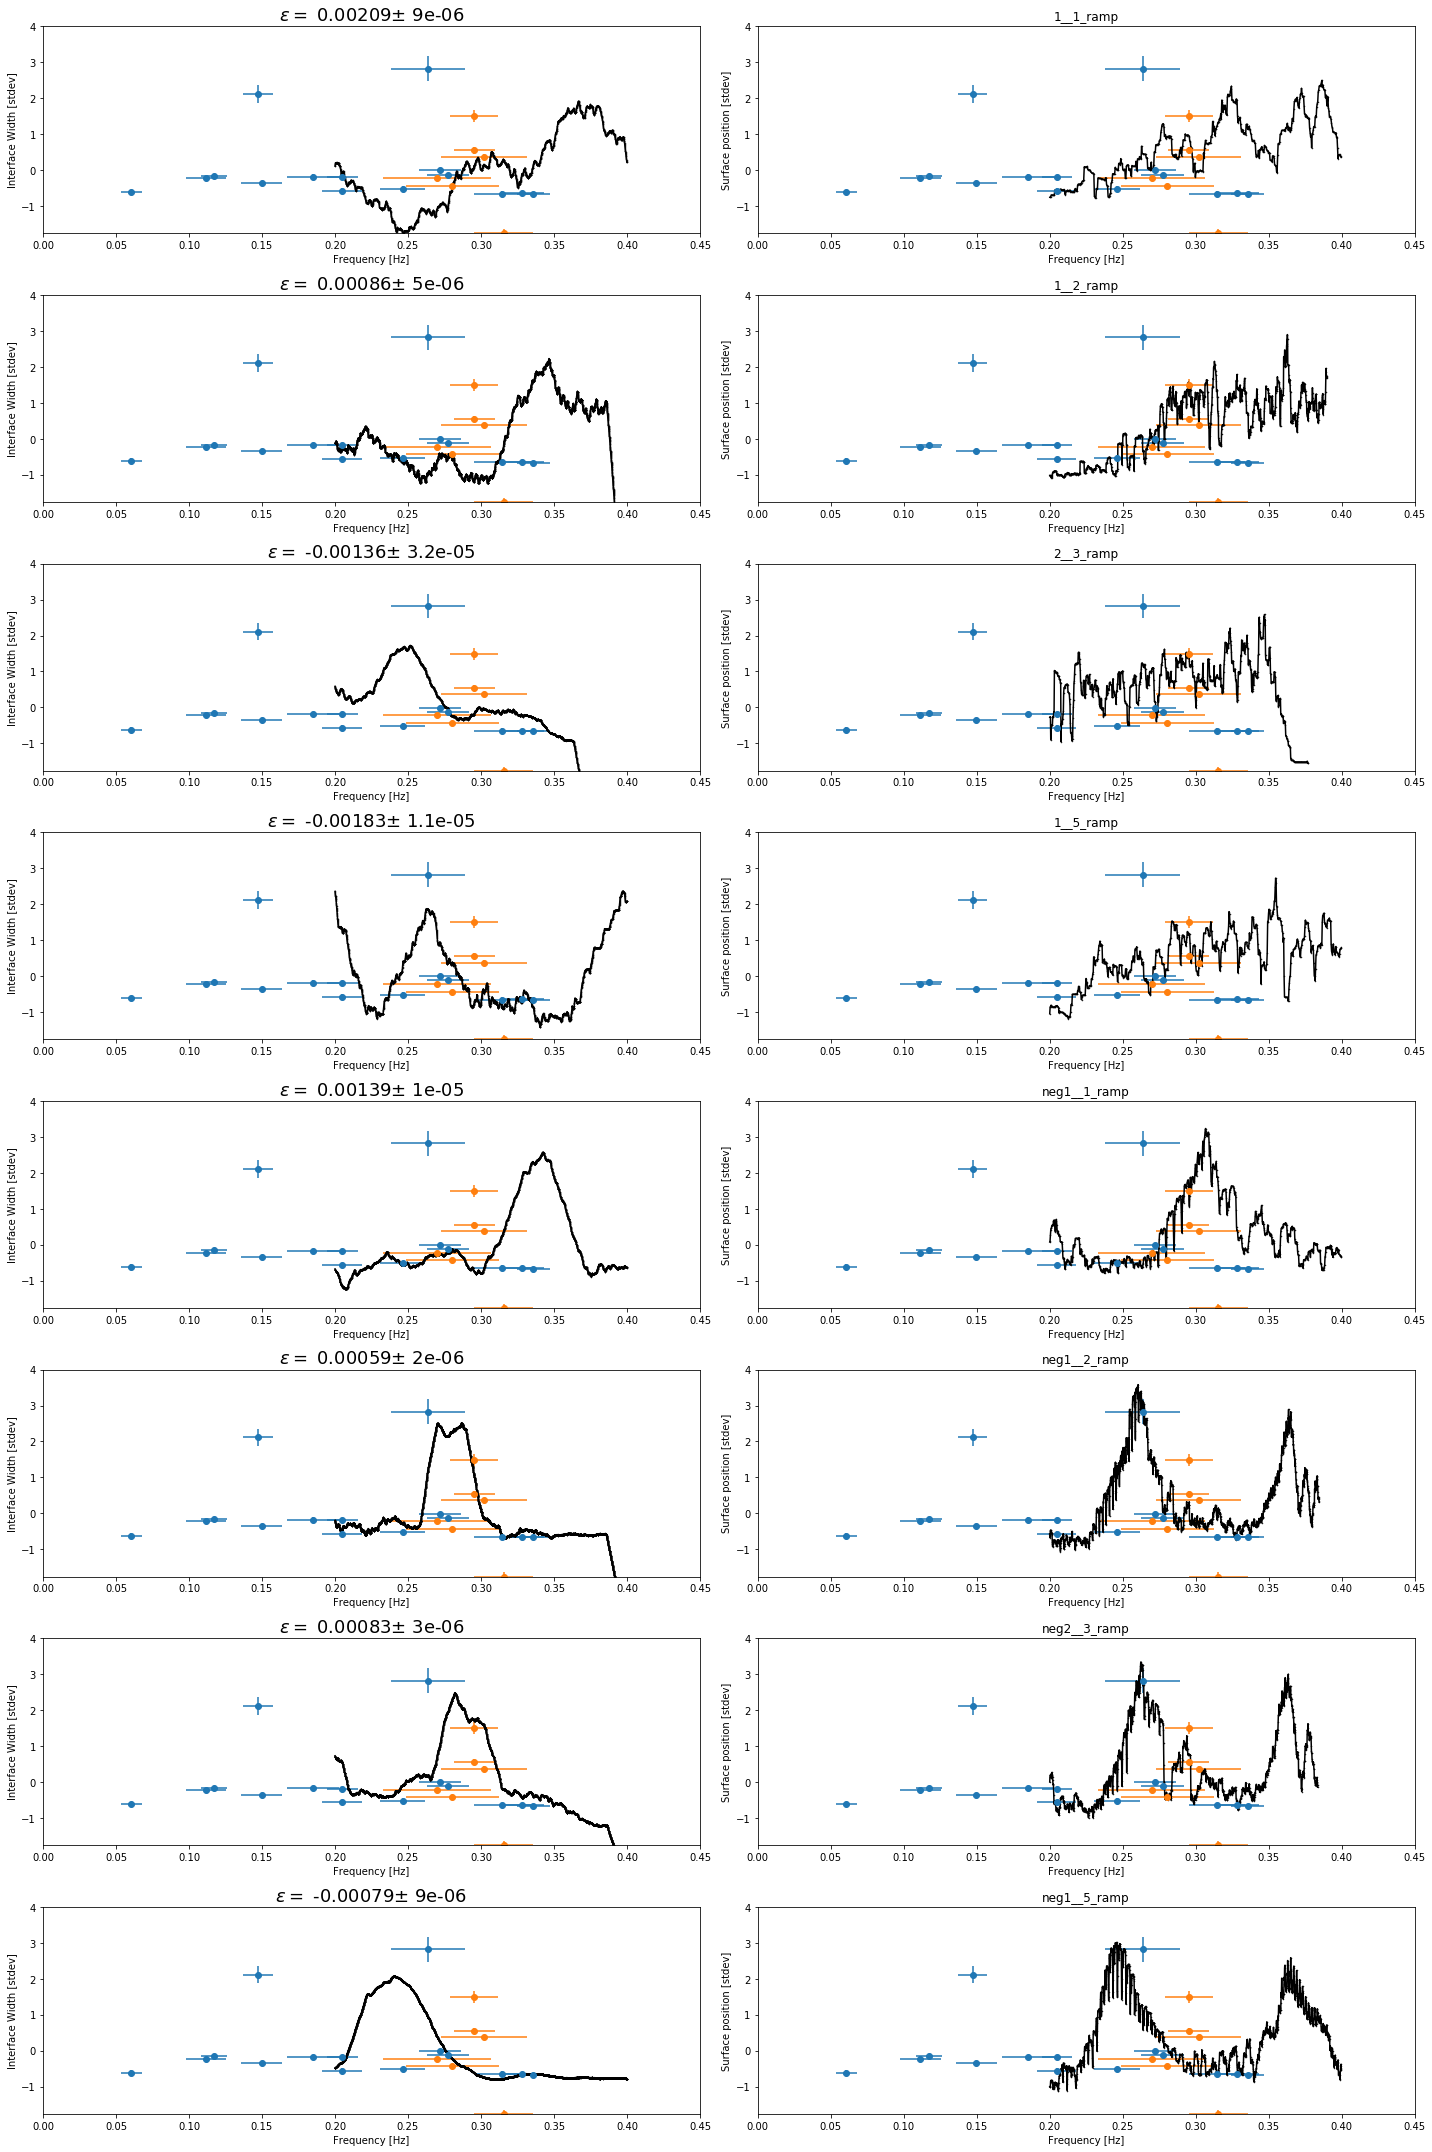

In [202]:
fig, axes = plt.subplots(8,2, figsize=(20,30))
axeslist = axes.flatten()
for i,e in enumerate(rampsData.values()):
    N = int(20*framerate)
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data/%s.dat' %e['driving']['name'])
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    dictionary['movingAvgw'] = normalize(movingAvgw)
    n = int(20)
    movingStdevSF = slidingStd(e['surface'][:,1], n)
    cont_frequencies = lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs'])
    filt = np.logical_and(cont_frequencies < 0.4, cont_frequencies > 0.2) ## cutting spectrum
    dictionary['surfacePos'] = normalize(movingStdevSF)
    dictionary['time'] = np.arange(0., data.shape[0], 1)/framerate
    ax = axes[:,0][i]
    ax2 = axes[:,1][i]
    ax.plot(cont_frequencies[filt], normalize(movingAvgw[filt]), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.set_title("$\epsilon = $ %s$\pm$ %s" %(round(e['driving']['coeffs'][0], 5), round(e['driving']['errors'][0], 6)) , fontsize=18)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Interface Width [stdev]')
    contFrequenciesSparse = lin(e['surface'][:,0], *e['driving']['coeffs']) ## with different sampling freq.
    filt2 = np.logical_and(contFrequenciesSparse < 0.4, contFrequenciesSparse > 0.2) ## cutting spectrum
    ax2.plot(contFrequenciesSparse[filt2], normalize(movingStdevSF)[filt2], '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax2.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax2.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax2.set_ylim(np.min(frozen2[:,1]), 4.)
    ax2.set_xlim(0., 0.45)
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Surface position [stdev]')
    e['interface'] = dictionary
    ax2.set_title(ramps[i])
    e['interfaceSurface'] = dictionary
fig.tight_layout()

In [70]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

[0.0013942  0.06474297]


C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


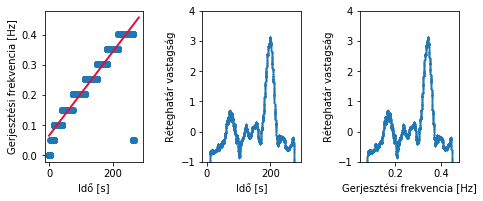

In [203]:
framerate = 29.18
figure, axes = plt.subplots(1, 3)
dataW = rampsData['quickRamp']['interfaceSurface']['movingAvgw']
e = rampsData['quickRamp']
time = rampsData['quickRamp']['driving']['t']
freqs = rampsData['quickRamp']['driving']['frequencies']
cont_frequencies = lin(np.arange(0., dataW.shape[0],1)/framerate, *e['driving']['coeffs'])
data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data/%s.dat' %e['driving']['name'])
movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
tim = np.arange(0., movingAvgw.shape[0],1)/framerate
cont_frequencies = lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs'])

dictionary['movingAvgw'] = normalize(movingAvgw)
print(e['driving']['coeffs'])
axes[0].plot(rampsData['quickRamp']['driving']['t'], freqs, 'o')
axes[0].plot(tim, cont_frequencies, '-', c='Crimson', linewidth=2.)

axes[1].plot(tim, normalize(movingAvgw), 'o', markersize= 0.5)
axes[2].plot(cont_frequencies, normalize(movingAvgw), 'o', markersize= 0.5)
axes[2].set_ylim(-1, 4)
axes[1].set_ylim(-1, 4)
axes[0].set_xlabel(r'Idő [s]')
axes[1].set_xlabel(r'Idő [s]')
axes[2].set_xlabel(r'Gerjesztési frekvencia [Hz]')
axes[0].set_ylabel(r'Gerjesztési frekvencia [Hz]')
axes[1].set_ylabel(r'Réteghatár vastagság')
axes[2].set_ylabel(r'Réteghatár vastagság')
figure.tight_layout()
ratio = 8./6.
figure.set_size_inches(3.5*2, 3.5/ratio)
plt.savefig('drifting_timeseries.pdf', bbox_inches='tight')

In [238]:
resonances= []
errors = []

In [141]:
def drawLine(position, height, width, ax):
    left = [position-width/2.,position + width/2.]
    right = [height,height]
    ax.plot(left, right, '-', c='Crimson', linewidth=2.)
    

In [158]:
def lorenz(x, x0, sigma, A):
    return A*sigma**2/((x - x0)**2 + sigma**2)

tipikus szélesség kb 0.1 Hz

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


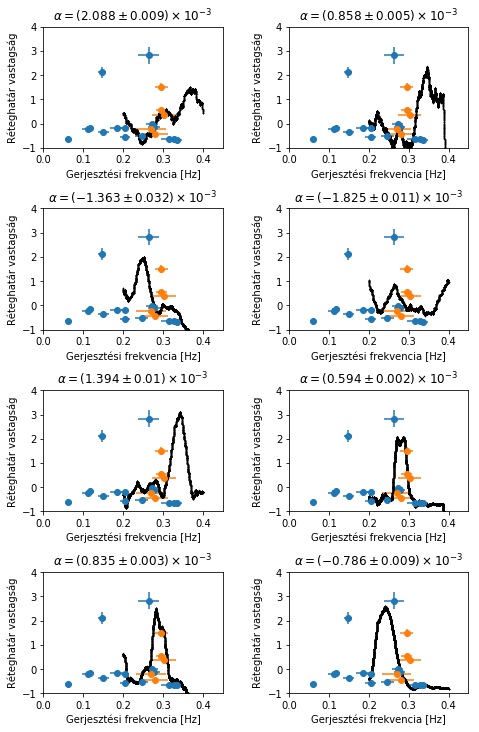

In [234]:
framerate = 29.18
figure, axes = plt.subplots(4, 2)
axeslist = axes.flatten()
for i,e in enumerate(rampsData.values()):
    time = e['driving']['t']
    freqs = e['driving']['frequencies']
    cont_frequencies = lin(np.arange(0., dataW.shape[0],1)/framerate, *e['driving']['coeffs'])
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data/%s.dat' %e['driving']['name'])
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    tim = np.arange(0., movingAvgw.shape[0],1)/framerate
    cont_frequencies = lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs'])
    ax = axeslist[i]
    filt = np.logical_and(cont_frequencies < 0.4, cont_frequencies > 0.2) ## cutting spectrum
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.plot(cont_frequencies[filt], normalize(movingAvgw)[filt], 'o', markersize= 0.5, c='black')
    ax.set_ylim(-1, 4)
    ax.set_ylim(-1, 4)
    ax.set_xlabel(r'Gerjesztési frekvencia [Hz]')
    ax.set_ylabel(r'Réteghatár vastagság')
    ax.set_title(r'$\alpha = (%s \pm %s)\times 10^{-3}$' %(round(e['driving']['coeffs'][0]*1000, 3), round(e['driving']['errors'][0]*1000, 3)))
figure.tight_layout()
ratio = 8./6.
figure.set_size_inches(3.5*2, 3.5*5/ratio)
plt.savefig('tablo1.pdf', bbox_inches='tight')

### Error calculation for the peaks:

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


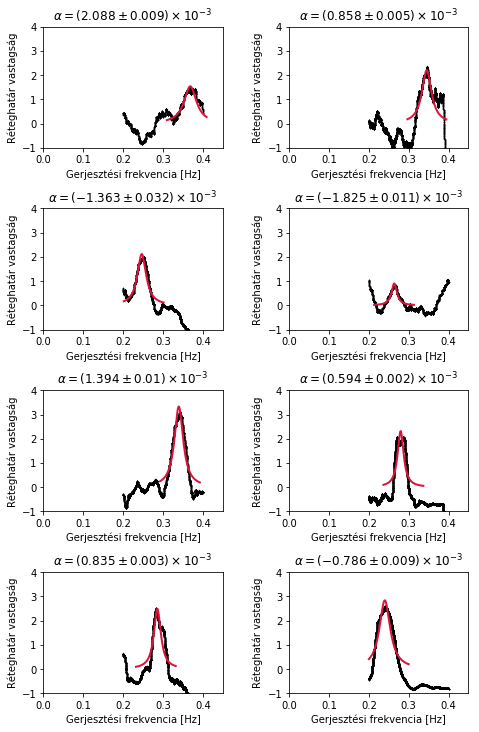

In [239]:
framerate = 29.18
figure, axes = plt.subplots(4, 2)
axeslist = axes.flatten()
for i,e in enumerate(rampsData.values()):
    time = e['driving']['t']
    freqs = e['driving']['frequencies']
    cont_frequencies = lin(np.arange(0., dataW.shape[0],1)/framerate, *e['driving']['coeffs'])
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data/%s.dat' %e['driving']['name'])
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    tim = np.arange(0., movingAvgw.shape[0],1)/framerate
    cont_frequencies = lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs'])
    ax = axeslist[i]
    filt = np.logical_and(cont_frequencies < 0.4, cont_frequencies > 0.2) ## cutting spectrum
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.plot(cont_frequencies[filt], normalize(movingAvgw)[filt], 'o', markersize= 0.5, c='black')
    ax.set_ylim(-1, 4)
    ax.set_ylim(-1, 4)
    ax.set_xlabel(r'Gerjesztési frekvencia [Hz]')
    ax.set_ylabel(r'Réteghatár vastagság')
    filt = np.logical_and(cont_frequencies < 0.36, cont_frequencies > 0.25) ## cutting spectrum
    maxPlace = np.argmax(movingAvgw[filt])
    maxFreq = cont_frequencies[filt][maxPlace]
    filtFit = np.logical_and(cont_frequencies < maxFreq+0.05, cont_frequencies > maxFreq-0.05)
    popt, pcov = curve_fit(lorenz, cont_frequencies[filtFit], normalize(movingAvgw)[filtFit], p0= (maxFreq, 0.1, 2., ))
    ax.plot(cont_frequencies[filtFit], lorenz(cont_frequencies[filtFit], *popt), '-',linewidth= 2., c='Crimson')
    resonances.append([ e['driving']['coeffs'][0], popt[0]] ) ##popt[0]: x0 parameter
    errors.append([e['driving']['errors'][0],popt[1]]) ## popt[1]: sigma parameter     
    ax.set_title(r'$\alpha = (%s \pm %s)\times 10^{-3}$' %(round(e['driving']['coeffs'][0]*1000, 3), round(e['driving']['errors'][0]*1000, 3)))
figure.tight_layout()
ratio = 8./6.
figure.set_size_inches(3.5*2, 3.5*5/ratio)
plt.show()

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


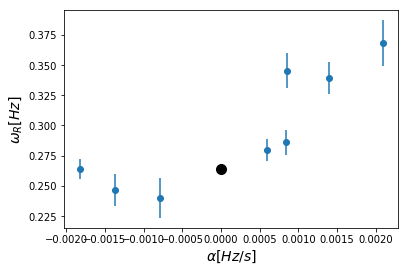

In [193]:

resonances = np.array(resonances)
errors = np.array(errors)
plt.errorbar(resonances[:,0], resonances[:,1], fmt='o', xerr=errors[:,0], yerr=errors[:,1])
plt.plot(0.,0.2637594513803412, 'o', c='black', markersize=10)
plt.xlabel(r'$\alpha [Hz/s]$', fontsize=14)
plt.ylabel(r'$\omega_R [Hz]$', fontsize=14)
plt.savefig('omega_alpha_.pdf', bbox_inches='tight')

In [192]:
print("resonance Freq ", frozen1[:,0][np.argmax(frozen1[:,1])])
print("error", frozen1[:,2][np.argmax(frozen1[:,1])])

resonance Freq  0.2637594513803412
error 0.025526315431400694


In [204]:
def sqrtFit(x, f0, d):
    return f0 + np.sign(x)*d*np.sqrt(x)

In [208]:
const = np.sqrt(3*np.pi/4.)

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


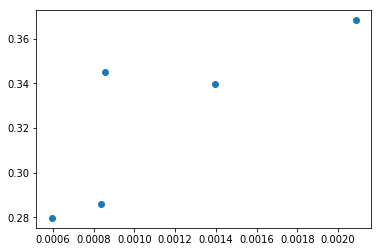

In [209]:
popt, pcov = curve_fit(sqrtFit, resonances[:,0][resonances[:,0]>0], resonances[:,1][resonances[:,0]>0], p0=(0.26, const, ))

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


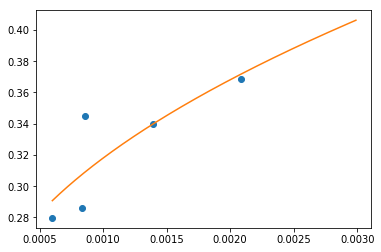

In [212]:
popt, pcov = curve_fit(sqrtFit, resonances[:,0][resonances[:,0]>0], resonances[:,1][resonances[:,0]>0], p0=(0.26, const, ))
plt.plot(resonances[:,0][resonances[:,0]>0], resonances[:,1][resonances[:,0]>0], 'o')
xplot = np.arange(0.0006, 0.003, 0.00001)
plt.plot(xplot, sqrtFit(xplot, *popt), '-')


In [213]:
popt

array([0.19698722, 3.8272461 ])

In [214]:
const

1.5349900619197328

C:\Users\balin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


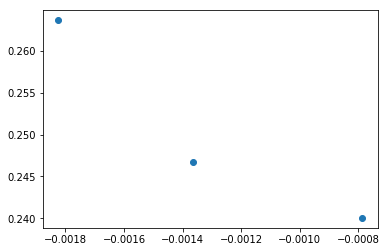

In [222]:

plt.plot(resonances[:,0][resonances[:,0]<0], resonances[:,1][resonances[:,0]<0], 'o')
popt, pcov = curve_fit(sqrtFit, resonances[:,0][resonances[:,0]<0], resonances[:,1][resonances[:,0]<0], p0=(0.26, -1*const, ))
xplot = np.arange(0., -0.003, 0.00001)
plt.plot(xplot, sqrtFit(xplot, *popt), '-')


### Including control measurements:

In [218]:
oneshillInterface = ['1_ak_ramp_0_75_rol_interface_runstdev_freq.dat', '1_ak_ramp_1_24_rol_interface_runstdev_freq.dat', '2_ak_ramp_1_24_rol_interface_runstdev_freq.dat', '2_ak_ramp_1_50_rol_le_interface_runstdev_freq.dat']
oneshillSurface = ['1_ak_ramp_0_75_rol_surface_runstdev_freq.dat', '1_ak_ramp_1_24_rol_surface_runstdev_freq.dat', '2_ak_ramp_1_24_rol_surface_runstdev_freq.dat', '2_ak_ramp_1_50_rol_le_surface_runstdev_freq.dat']



In [241]:
alphas = [0.00065, 0.00073, 0.00067, -0.00062]

0.00010833999999998456
0.00012167000000001815
0.0001116599999999579
-0.00010334000000000731


C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

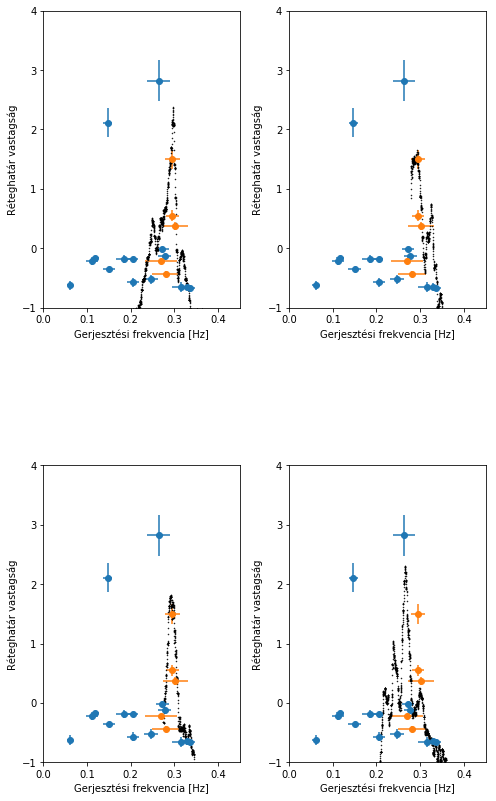

In [242]:
plt.clf()
framerate = 29.18
figure, axes = plt.subplots(2, 2)
axeslist = axes.flatten()
for i,e in enumerate(oneshillInterface):
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0526/%s' %e)
    ax = axeslist[i]
    freqs = data[:,0]
    filt = np.logical_and(data[:,0] < 0.4, data[:,0] > 0.2) ## cutting spectrum
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.plot(freqs[filt], normalize(data[:,1])[filt], 'o', markersize= 0.5, c='black')
    ax.set_ylim(-1, 4)
    ax.set_ylim(-1, 4)
    ax.set_xlabel(r'Gerjesztési frekvencia [Hz]')
    ax.set_ylabel(r'Réteghatár vastagság')
    alpha = freqs[1] - freqs[0]
    print(alpha)
    maxPlace = np.argmax(data[:,1][filt])
    maxFreq = freqs[filt][maxPlace]
    resonances.append([alphas[i], maxFreq])
    errors.append([0., 0.])
    #ax.set_title(r'$\alpha = %s\times 10^{-3}$' %alpha*1000)
figure.tight_layout()
ratio = 8./6.
figure.set_size_inches(3.5*2, 3.5*5/ratio)
plt.show()

Text(0,0.5,'$\\omega_R [Hz]$')

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


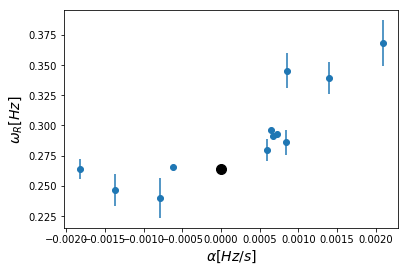

In [243]:

resonances = np.array(resonances)
errors = np.array(errors)
plt.errorbar(resonances[:,0], resonances[:,1], fmt='o', xerr=errors[:,0], yerr=errors[:,1])
plt.plot(0.,0.2637594513803412, 'o', c='black', markersize=10)
plt.xlabel(r'$\alpha [Hz/s]$', fontsize=14)
plt.ylabel(r'$\omega_R [Hz]$', fontsize=14)
#plt.savefig('omega_alpha_.pdf', bbox_inches='tight')

C:\Users\balin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


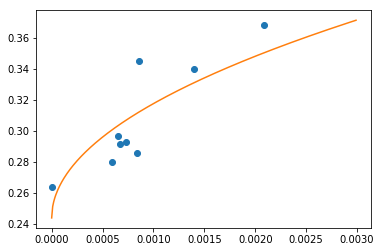

In [247]:
resonances_ = np.zeros((len(resonances)+1, 2))
resonances_[0] = np.array([0., 0.2637594513803412])
resonances_[1:] = resonances
popt, pcov = curve_fit(sqrtFit, resonances_[:,0][resonances_[:,0]>=0], resonances_[:,1][resonances_[:,0]>=0], p0=(0.26, const, ))
plt.plot(resonances_[:,0][resonances_[:,0]>=0], resonances_[:,1][resonances_[:,0]>=0], 'o')
xplot = np.arange(0.000, 0.003, 0.00001)
plt.plot(xplot, sqrtFit(xplot, *popt), '-')


In [248]:
errors = np.sqrt(np.diag(pcov))
print('f0 = ', popt[0], ' +/- ', errors[0])
print('d= ', popt[1], ' +/- ', errors[1])


f0 =  0.24391728444797015  +/-  0.0186608815014096
d=  2.32716369964365  +/-  0.63314242874246


In [249]:
def sqrtFitGam(x, f0, d, gam):
    return f0 + np.sign(x)*d*x**gam

In [253]:

popt, pcov = curve_fit(sqrtFitGam, resonances[:,0][resonances[:,0]>=0], resonances[:,1][resonances[:,0]>=0], p0=(0.26, const, 0.5,))
plt.plot(resonances[:,0][resonances[:,0]>=0], resonances[:,1][resonances[:,0]>=0], 'o')
xplot = np.arange(0.000, 0.003, 0.00001)
plt.plot(xplot, sqrtFitGam(xplot, *popt), '-')


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [251]:
errors = np.sqrt(np.diag(pcov))
print('f0 = ', popt[0], ' +/- ', errors[0])
print('d= ', popt[1], ' +/- ', errors[1])
print('gamma = ', popt[2], ' +/- ', errors[2])

f0 =  0.26064119216944165  +/-  0.018651454882185562
d=  55.06678736431382  +/-  131.43293022780932
gamma =  1.0045847607195448  +/-  0.3937388076335779
